# <u> 2015 World Happines Report Final Project </u>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline
import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# <u> 1. Data Set Description <u>

<ul>
<li> <b> happy1 </b>is a dataset of happiness score of countries in 2015. Each row is a country and its respective happiness score(how pleasant the life is in country). </li>
<li> <b> fact</b> is a dataset of countries during 2000-2015. Each row contains unemployment rate, inflation and GDP per capita current dollars for each country and year. </li>
<li> <b> edu</b> is a dataset of countries during 2000-2016. Each row contains Female to male students ratio at tertiary level education for each country for a particular year.</li>    
<li> <b> happy </b> is the merged dataset between <b> happy1 </b> , <b> fact </b> and <b> edu </b>.
</ul>

Important columns in <b> happy1 </b> are:
<ol>
<li> Country: Name of the country. </li>
<li> Happiness Rank: Rank of the country based on the Happiness Score. </li>
<li> Happiness Score: A metric measured in 2015 by asking the sampled people the question:- How would you rate your happiness on a scale of 0 to 10 where 10 is the happiest. </li>
<li> Family: The extent to which Family contributes to the calculation of the Happiness Score </li>
<li> Health (Life Expectancy): The extent to which Life expectancy contributed to the calculation of the Happiness Score </li>
<li> Freedom: The extent to which Freedom contributed to the calculation of the Happiness Score. </li>
<li> Trust (Government Corruption): The extent to which Perception of Corruption contributes to Happiness Score. </li>

</ol>

Important columns in <b> fact </b> are:
<ol>
<li> Inflation: Inflation rate of a country in a particular year. </li>
<li> Unemployment rate: Unemployment rate of a country in a particular year. </li>
<li> GDP per capita current dollars: current GDP per capita of a country in dollars. </li>
</ol>

Important columns in <b> edu </b> are:
<ol>
<li> Female to male ratio students at tertiary level education: Female to male students ratio at tertiary level education. </li>
</ol>

In [2]:
happy1 = pd.read_csv('2015.csv',encoding = 'latin1')
fact = pd.read_csv('unemploy.csv',encoding = 'latin1')
edu = pd.read_csv('female_edu.csv',encoding = 'latin1')

In [3]:
happy1.head(2)

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201


In [4]:
fact.head(2)

,Country,Code,Year,Inflation,Unemployment rate,GDP per capita current dollars
0,Afghanistan,AFG,2000,,11.18,
1,Afghanistan,AFG,2001,,11.58,117.41


In [5]:
edu.head(2)

,Country,Code,Year,Female to male ratio students at tertiary level education
0,Afghanistan,AFG,2003,0.28
1,Afghanistan,AFG,2004,0.28


# <u> 2. Data Preparation </u>

### Table 1

Created subset of rows having year 2015 only in the dataset.

In [6]:
edu=edu[edu.Year==2015]

In [7]:
n=edu.columns.tolist()
n[-1]='female_edu'
edu.columns=n

In [8]:
edu=edu.drop(columns=['Code','Year'])

In [9]:
edu.head(2)

,Country,female_edu
20,Albania,1.53
32,Algeria,1.56


### Table 2

Created subset of rows having year 2015 only in the dataset.

In [10]:
fact=fact[fact.Year==2015]

In [11]:
fact.head(2)

,Country,Code,Year,Inflation,Unemployment rate,GDP per capita current dollars
15,Afghanistan,AFG,2015,-0.7,8.86,569.58
31,Albania,ALB,2015,1.9,17.08,3952.83


Converted Inflation, unemployment rate and GDP into float from string type. We cannot use "astype()" directly because string values in these columns contains space(" ") and symbols which need to be removed first before converting and added again after converting. 

In [12]:
fact['positive']=(fact[' Inflation'].str.contains('-'))*(-1)+(~fact[' Inflation'].str.contains('-'))*1

Countries that have missing inflation values are very less in numbers, they are set to the mean.

In [13]:
fact[' Inflation']=fact[' Inflation'].replace({' ':'1000.0'})
fact['inflation']=fact[' Inflation'].apply(lambda r:r.strip(' -').split('.')).apply(lambda r: 
                  (float(r[0]))*1+(int(r[1])*0.1)if len(r)==2 else float(r[0]))
fact['inflation']=fact.inflation*fact.positive
fact['inflation']=fact['inflation'].replace({1000.0:fact['inflation'][fact.inflation!=1000].mean()})


Countries that have missing Unemployment rate values are very less in numbers, they are set to the mean.

In [14]:
fact[' Unemployment rate']=fact[' Unemployment rate'].replace({' ':'1000.0'})
fact['unemployment_rate']=fact[' Unemployment rate'].apply(lambda r:
                          r.strip(' ').split('.')).apply(lambda r: (float(r[0]))*1+(int(r[1][0])*0.1)if len(r)==2 else float(r[0]))
fact['unemployment_rate']=fact['unemployment_rate'].replace({1000.0:fact['unemployment_rate'][fact.unemployment_rate!=1000].mean()})


Countries with missing values in GDP are dropped and GDP values are converted to float type.

In [15]:
fact=fact[fact[' GDP per capita current dollars']!=' ']
fact['GDP']=fact[' GDP per capita current dollars'].apply(lambda r:
            r.strip(' -').split('.')).apply(lambda r: (float(r[0]))*1+(int(r[1][0])*0.1)if len(r)==2 else float(r[0]))



Dropped columns that are not important

In [16]:
fact1=fact.drop(columns=['Code','Year',' Inflation',' Unemployment rate',' GDP per capita current dollars','positive'])


### Table 3

Dropped columns that are not important

In [17]:
happy1=happy1.drop(columns=['Region','Economy (GDP per Capita)','Standard Error','Dystopia Residual'])

<u> We choose Happniess rank to represent Happiness level, and convert it to a score of 1 to 100. </u>

In [18]:
happy1['happy_score']=happy1['Happiness Rank'].rank(ascending=False,method='min')*100/158

### Merge three table

In [19]:
happy=happy1.merge(fact1)

In [20]:
happy=happy.merge(edu)

<u> Rearrange column order </u>

In [21]:
n=happy.columns.tolist()

In [22]:
n.insert(1,n.pop(8))

In [23]:
happy=happy.reindex(columns=n)

In [24]:
happy=happy.drop(columns=['Happiness Rank','Happiness Score'])

In [25]:
happy.head(5)

,Country,happy_score,Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,inflation,unemployment_rate,GDP,female_edu
0,Switzerland,100.000000,1.34951,0.94143,0.66557,0.41978,0.29678,-1.1,4.8,82016.0,1.03
1,Iceland,99.367089,1.40223,0.94784,0.62877,0.14145,0.43630,1.6,3.9,51213.6,1.79
2,Denmark,98.734177,1.36058,0.87464,0.64938,0.48357,0.34139,0.5,6.1,53013.0,1.40
3,Norway,98.101266,1.33095,0.88521,0.66973,0.36503,0.34699,2.2,4.3,74498.1,1.46
4,Finland,96.835443,1.31826,0.88911,0.64169,0.41372,0.23351,-0.2,9.3,42424.2,1.20


# <u> 3. Interesting Finding Summary </u>

<b>Finding</b>:
When sense of freedom increase, the happiness score increase dramatically, but it is only for countries that have GDP above 8409.7. However, sense of freedom has insignificant effect on happiness score for countries that have GDP below 8409.7.

# <u> 4. Machine Learning: Decision Tree </u>

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

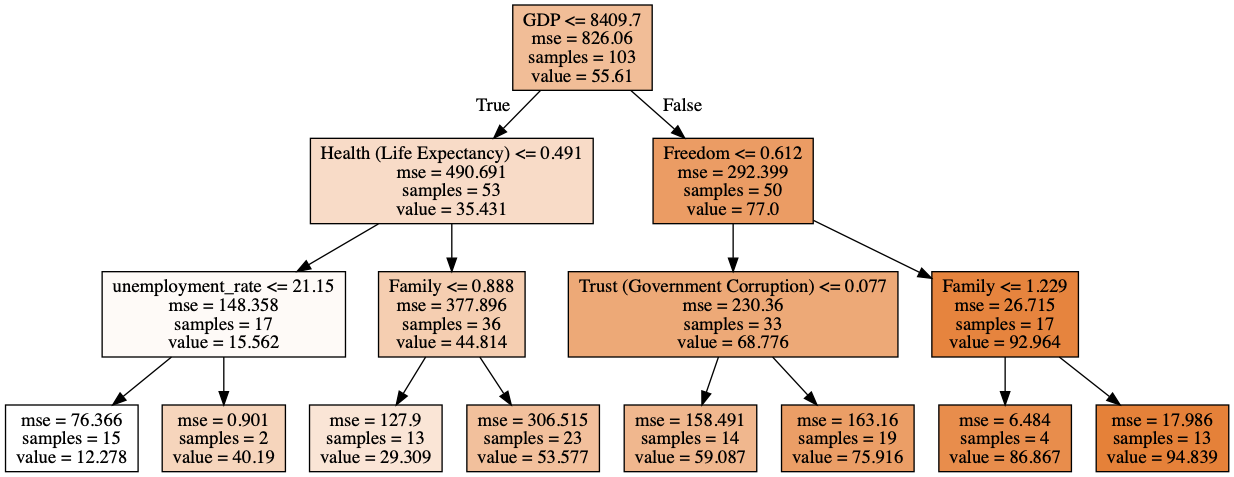

In [26]:
X = happy.drop(columns = ['Country','happy_score'])
Y = happy['happy_score']
import sklearn.tree as tree
dt = tree.DecisionTreeRegressor(max_depth = 3,random_state=0)
dt.fit(X,Y)

dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.str) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

In [27]:
happiness=happy.copy()

In [28]:
happiness.columns

Index(['Country', 'happy_score', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity', 'inflation',
       'unemployment_rate', 'GDP', 'female_edu'],
      dtype='object')

# <u> 5. Validity of the Finding </u>

In [29]:
happiness['bin_health']=pd.cut(happy['Health (Life Expectancy)'],bins=[-0.01,0.5,100])
happiness['bin_gdp']=pd.cut(happiness['GDP'],bins=[-0.01,8409.7,100000000])
happiness['bin_freedom']=pd.cut(happy['Freedom'],bins=[-0.01,0.612,1000])
happiness['bin_female_edu']=pd.cut(happiness['female_edu'],bins=[-0.1,1.17,100])
happiness['bin_unemploy']=pd.cut(happiness['unemployment_rate'],bins=[-0.1,21.15,10000])
happiness['bin_trust']=pd.cut(happiness['Trust (Government Corruption)'],bins=[-0.1,0.077,100])
happiness['bin_family']=pd.cut(happiness['Family'],bins=10)

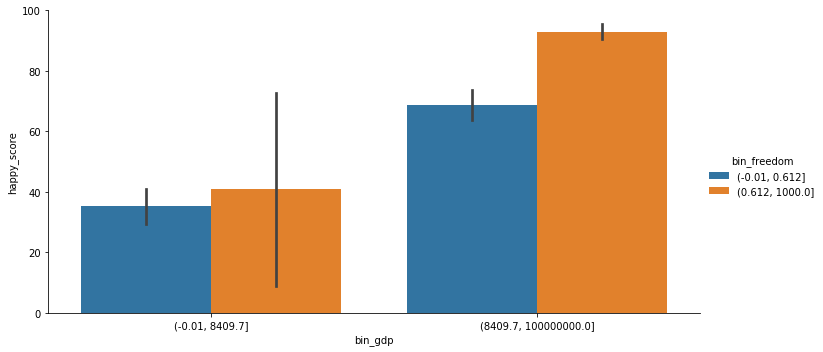

In [30]:
sns.factorplot(x='bin_gdp', y='happy_score',hue='bin_freedom',data=happiness, kind='bar',aspect=2)

Finding: Among countries that have GDP above 8409.7, countries that have high sense of freedom  have high happy score compared to countries with low sense of freedom. 

# <u> 6.  Managerial Insights</u>

Freedom plays an important role in defining how pleasant the life is in countries that have GDP above 8409.7, but not for countries below GDP 8409.7. High GDP countries can act on this information to focus more on increasing the sense of freedom among the people by improving the policices concerned with freedom for people or by some other measures so that they can stand high on World Happiness Ranking.

Countries with high GDP have higher social welfare, sufficient material supply, and the people's material living standards are guaranteed. Therefore, they are more eager to pursue spiritual freedom, freedom of speech, etc., and this increase in freedom will make them feel satisfied and happy. In countries with low GDP, social security is low, and people's material living standards are not guaranteed. The material level of food and clothing is still the main happiness indicator of people. Before the material living standard is guaranteed, the spiritual level of freedom will not influence their happiness a lot.

Therefore, when the country’s GDP reaches a high level, government should pay more attention to the freedom of rights and political democratization of the people.
For example, people can participate more broadly in free and fair national elections, strengthen freedom of the press and freedom of speech, give people more freedom to access diverse information, and express their freedom more freely.
And citizens have more freedom of choice and speaking in their work. For those countries with low GDP levels, more funds should be invested in strengthening infrastructure construction, improving medical standards, promoting social security, and solving life problems at the national material level.
These measures can effectively improve the happiness of the people.
